## Classifying Good Product Reviews: Deep Learning Model

### Organize imports

In [1]:
from gensim.models import Word2Vec
from lib.amazon_model import *
from lib.data_mgmt import *
from nltk.data import find
from sklearn.metrics import roc_curve, auc

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%autosave 5

Autosaving every 5 seconds


### add check in order to see if TensorFlow with GPU is used

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4959548429195866029, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15770877952
 locality {
   bus_id: 1
 }
 incarnation: 16824904216440081641
 physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:02:00.0, compute capability: 6.1"]

### Set network parameters

In [3]:
# Dataset/Featurization Config
path = 'data/full_cols_good_50k.csv'
label = 'good'
max_size = 200
max_tfidf = 12000
n_classes = 2
n_features = 300
test_size = 0.25
verbose = True

# LSTM Config
lstm_size = 50
num_lstm_layers = 2
lstm_dropout = 0.15

# FC Config
fc_layer_sizes = [75, 50, 30]
fc_dropout = 0.10

# Training config
run_name = label + '_run_' + path.split('.')[0].split('_')[-1]
learning_rate = 1e-3
reg_weight = 1e-5
training_iters = 15000 * 10
batch_size = 15
display_step = 10
save_every = 5000
save_fn = 'chkpts/model_' + run_name + '.ckpt'
should_log_metrics = True

In [4]:
training_loss_iter_fn = 'log/training_loss_iter_' + run_name + '.csv'
training_acc_iter_fn = 'log/training_acc_iter_' + run_name + '.csv'
testing_loss_iter_fn = 'log/testing_loss_iter_' + run_name + '.csv'
testing_acc_iter_fn = 'log/testing_acc_iter_' + run_name + '.csv'

### Set up word embedding model

In [5]:
%%time
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
we_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

CPU times: user 8.39 s, sys: 172 ms, total: 8.56 s
Wall time: 8.57 s


### Configure dataset

In [6]:
%%time
dataset = Dataset(path, we_model, {
    'label'      : label,
    'max_size'   : max_size,
    'max_tfidf'  : max_tfidf,
    'n_features' : n_features,
    'test_size'  : test_size,
    'verbose'    : verbose
})

n_cols = dataset.get_n_cols() # Number of additional DNN features (including tf-idf features)

Initializing dataset at data/full_cols_good_50k.csv.
Splitting training and test sets.
Building reviewer/ASIN maps.
Fitting tf-idf featurizer.
doc list created: 50000
Tuning tf-idf classifier.


/u/44/prollm1/unix/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Featurizing training set.
Featurizing test set.
Finished configuring dataset.
CPU times: user 35min 50s, sys: 1min 25s, total: 37min 16s
Wall time: 7min 23s


### Prepare model configurations

In [7]:
class ModelConfig(object):
    def __init__(self):
        self.lstm_size = lstm_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm_keep_prob = 1.0 - lstm_dropout
        self.fc_keep_prob = 1.0 - fc_dropout
        self.learning_rate = learning_rate
        self.reg_weight = reg_weight
        self.fc_layer_sizes = fc_layer_sizes
        self.n_classes = n_classes
        self.n_cols = n_cols
        self.n_fc_layers = len(fc_layer_sizes) + 1

config = ModelConfig()

### Set up Tensorflow Graph

In [8]:
tf.reset_default_graph()

amazon_model = AmazonModel(config)
pred = amazon_model.build_graph()

In [9]:
# Input placeholders
x = tf.placeholder("float", [None, max_size, n_features])
x2 = tf.placeholder("float", [None, n_cols])
seqlen = tf.placeholder(tf.int32, [None])
lstm_keep_prob = tf.placeholder(tf.float32)
fc_keep_prob = tf.placeholder(tf.float32)

# Output placeholder
y = tf.placeholder("float", [None, n_classes])

# Checkpointing
saver = tf.train.Saver()

In [10]:
# Run forward pass
logits, weights = pred(x, x2, seqlen, lstm_keep_prob, fc_keep_prob)

# Define loss and optimizer
cost = tf.add(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)),
              amazon_model.regularization_penalty())

optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

/u/44/prollm1/unix/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [11]:
# Initializing the variables
init = tf.global_variables_initializer()

### Train model

In [ ]:
if should_log_metrics:
    train_loss_log = open(training_loss_iter_fn, 'a')
    test_loss_log = open(testing_loss_iter_fn, 'a')
    train_acc_log = open(training_acc_iter_fn, 'a')
    test_acc_log = open(testing_acc_iter_fn, 'a')

Iter 150, Minibatch Loss= 0.677008, Training Accuracy= 0.60000
Iter 300, Minibatch Loss= 0.663271, Training Accuracy= 0.80000
Iter 450, Minibatch Loss= 0.721575, Training Accuracy= 0.33333
Iter 600, Minibatch Loss= 0.621094, Training Accuracy= 0.66667
Iter 750, Minibatch Loss= 0.668478, Training Accuracy= 0.60000
Validation Accuracy: 0.6284
Validation Loss: 0.6749832


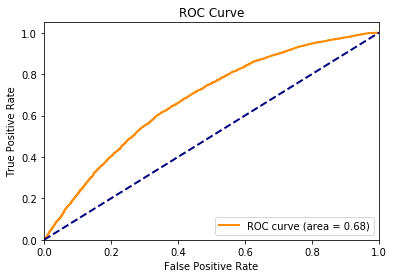

Iter 900, Minibatch Loss= 0.679148, Training Accuracy= 0.73333
Iter 1050, Minibatch Loss= 0.614837, Training Accuracy= 0.80000
Iter 1200, Minibatch Loss= 0.691697, Training Accuracy= 0.53333
Iter 1350, Minibatch Loss= 0.678292, Training Accuracy= 0.66667
Iter 1500, Minibatch Loss= 0.687084, Training Accuracy= 0.46667
Validation Accuracy: 0.63048
Validation Loss: 0.66420174


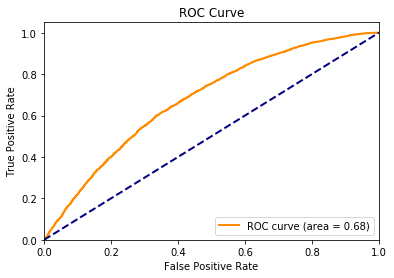

Iter 1650, Minibatch Loss= 0.661408, Training Accuracy= 0.60000
Iter 1800, Minibatch Loss= 0.555200, Training Accuracy= 0.80000
Iter 1950, Minibatch Loss= 0.557743, Training Accuracy= 0.66667
Iter 2100, Minibatch Loss= 0.698050, Training Accuracy= 0.33333
Iter 2250, Minibatch Loss= 0.610740, Training Accuracy= 0.80000
Validation Accuracy: 0.62776
Validation Loss: 0.6556618
Iter 2400, Minibatch Loss= 0.646261, Training Accuracy= 0.66667
Iter 2550, Minibatch Loss= 0.724252, Training Accuracy= 0.46667
Iter 2700, Minibatch Loss= 0.574357, Training Accuracy= 0.53333
Iter 2850, Minibatch Loss= 0.681962, Training Accuracy= 0.60000
Iter 3000, Minibatch Loss= 0.581013, Training Accuracy= 0.73333
Validation Accuracy: 0.634
Validation Loss: 0.6429182


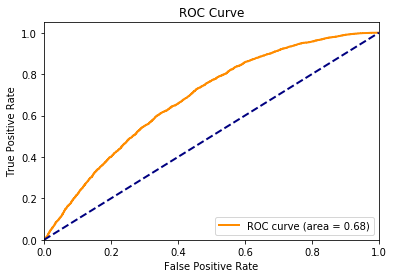

Iter 3150, Minibatch Loss= 0.546218, Training Accuracy= 0.60000
Iter 3300, Minibatch Loss= 0.560212, Training Accuracy= 0.73333
Iter 3450, Minibatch Loss= 0.694100, Training Accuracy= 0.60000
Iter 3600, Minibatch Loss= 0.676763, Training Accuracy= 0.53333
Iter 3750, Minibatch Loss= 0.597426, Training Accuracy= 0.66667
Validation Accuracy: 0.63024
Validation Loss: 0.64654905
Iter 3900, Minibatch Loss= 0.550217, Training Accuracy= 0.73333
Iter 4050, Minibatch Loss= 0.651310, Training Accuracy= 0.53333
Iter 4200, Minibatch Loss= 0.680914, Training Accuracy= 0.46667
Iter 4350, Minibatch Loss= 0.759130, Training Accuracy= 0.46667
Iter 4500, Minibatch Loss= 0.601513, Training Accuracy= 0.66667
Validation Accuracy: 0.64768
Validation Loss: 0.6315954


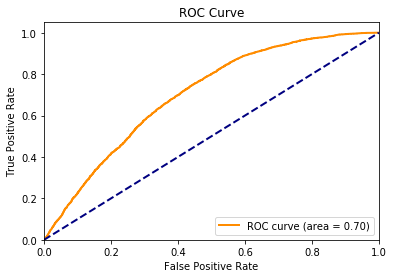

Iter 4650, Minibatch Loss= 0.570678, Training Accuracy= 0.66667
Iter 4800, Minibatch Loss= 0.767851, Training Accuracy= 0.40000
Iter 4950, Minibatch Loss= 0.580051, Training Accuracy= 0.66667
Iter 5100, Minibatch Loss= 0.747606, Training Accuracy= 0.46667
Iter 5250, Minibatch Loss= 0.591234, Training Accuracy= 0.80000
Validation Accuracy: 0.64416
Validation Loss: 0.63263476
Iter 5400, Minibatch Loss= 0.717871, Training Accuracy= 0.53333
Iter 5550, Minibatch Loss= 0.549093, Training Accuracy= 0.80000
Iter 5700, Minibatch Loss= 0.645456, Training Accuracy= 0.60000
Iter 5850, Minibatch Loss= 0.624611, Training Accuracy= 0.80000
Iter 6000, Minibatch Loss= 0.724880, Training Accuracy= 0.53333
Validation Accuracy: 0.64776
Validation Loss: 0.6275277


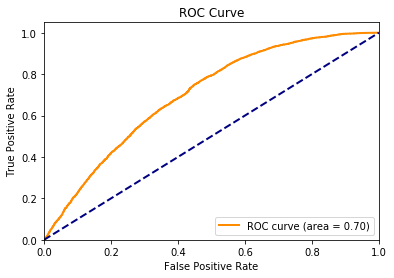

Iter 6150, Minibatch Loss= 0.506691, Training Accuracy= 0.73333
Iter 6300, Minibatch Loss= 0.787581, Training Accuracy= 0.46667
Iter 6450, Minibatch Loss= 0.688221, Training Accuracy= 0.46667
Iter 6600, Minibatch Loss= 0.610374, Training Accuracy= 0.73333
Iter 6750, Minibatch Loss= 0.704329, Training Accuracy= 0.40000
Validation Accuracy: 0.648
Validation Loss: 0.6337958


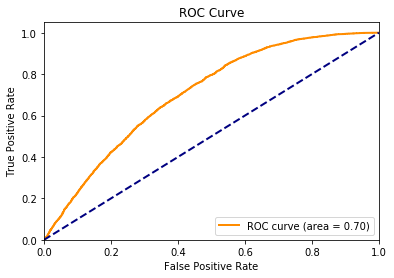

Iter 6900, Minibatch Loss= 0.659275, Training Accuracy= 0.66667
Iter 7050, Minibatch Loss= 0.614112, Training Accuracy= 0.60000
Iter 7200, Minibatch Loss= 0.490237, Training Accuracy= 0.86667
Iter 7350, Minibatch Loss= 0.531541, Training Accuracy= 0.73333
Iter 7500, Minibatch Loss= 0.673110, Training Accuracy= 0.66667
Validation Accuracy: 0.6656
Validation Loss: 0.6043638


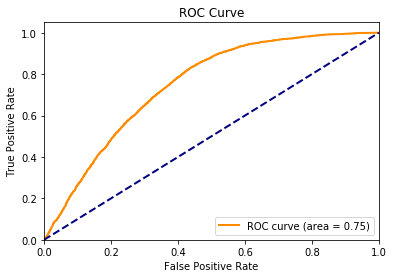

Iter 7650, Minibatch Loss= 0.589731, Training Accuracy= 0.66667
Iter 7800, Minibatch Loss= 0.580269, Training Accuracy= 0.60000
Iter 7950, Minibatch Loss= 0.784584, Training Accuracy= 0.66667
Iter 8100, Minibatch Loss= 0.513847, Training Accuracy= 0.86667
Iter 8250, Minibatch Loss= 0.583300, Training Accuracy= 0.73333
Validation Accuracy: 0.6988
Validation Loss: 0.60195297


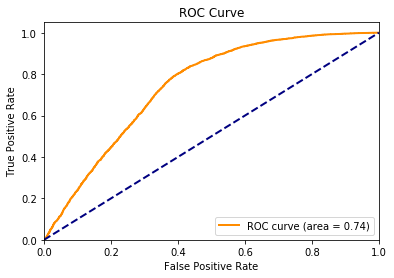

Iter 8400, Minibatch Loss= 0.488145, Training Accuracy= 0.86667
Iter 8550, Minibatch Loss= 0.562647, Training Accuracy= 0.66667
Iter 8700, Minibatch Loss= 0.543521, Training Accuracy= 0.80000
Iter 8850, Minibatch Loss= 0.610237, Training Accuracy= 0.66667
Iter 9000, Minibatch Loss= 0.586315, Training Accuracy= 0.73333
Validation Accuracy: 0.7132
Validation Loss: 0.5786451


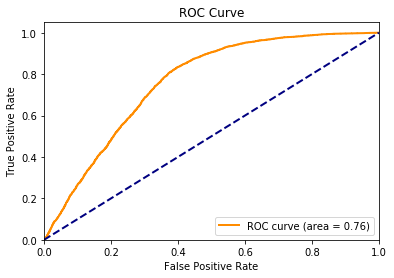

Iter 9150, Minibatch Loss= 0.550718, Training Accuracy= 0.73333
Iter 9300, Minibatch Loss= 0.551504, Training Accuracy= 0.60000
Iter 9450, Minibatch Loss= 0.650350, Training Accuracy= 0.46667
Iter 9600, Minibatch Loss= 0.731278, Training Accuracy= 0.73333
Iter 9750, Minibatch Loss= 0.423071, Training Accuracy= 0.80000
Validation Accuracy: 0.6248
Validation Loss: 0.67725587
Iter 9900, Minibatch Loss= 0.727938, Training Accuracy= 0.66667
Iter 10050, Minibatch Loss= 0.522516, Training Accuracy= 0.93333
Iter 10200, Minibatch Loss= 0.745390, Training Accuracy= 0.53333
Iter 10350, Minibatch Loss= 0.728359, Training Accuracy= 0.73333
Iter 10500, Minibatch Loss= 0.402839, Training Accuracy= 0.86667
Validation Accuracy: 0.6844
Validation Loss: 0.5866545
Iter 10650, Minibatch Loss= 0.657006, Training Accuracy= 0.60000
Iter 10800, Minibatch Loss= 0.762884, Training Accuracy= 0.53333
Iter 10950, Minibatch Loss= 0.681648, Training Accuracy= 0.60000
Iter 11100, Minibatch Loss= 0.594086, Training Acc

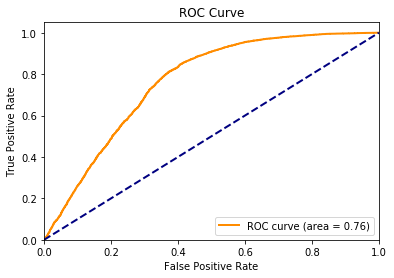

Iter 12900, Minibatch Loss= 0.629430, Training Accuracy= 0.73333
Iter 13050, Minibatch Loss= 0.668191, Training Accuracy= 0.66667
Iter 13200, Minibatch Loss= 0.532135, Training Accuracy= 0.73333
Iter 13350, Minibatch Loss= 0.579119, Training Accuracy= 0.73333
Iter 13500, Minibatch Loss= 0.463778, Training Accuracy= 0.86667
Validation Accuracy: 0.72904
Validation Loss: 0.5704688


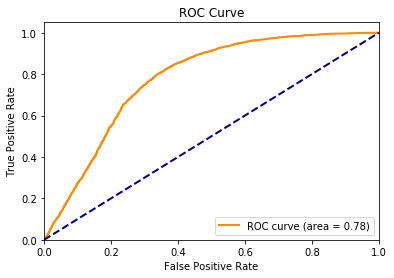

Iter 13650, Minibatch Loss= 0.613459, Training Accuracy= 0.66667
Iter 13800, Minibatch Loss= 0.656298, Training Accuracy= 0.53333
Iter 13950, Minibatch Loss= 0.640896, Training Accuracy= 0.66667
Iter 14100, Minibatch Loss= 0.565326, Training Accuracy= 0.73333
Iter 14250, Minibatch Loss= 0.439192, Training Accuracy= 0.86667
Validation Accuracy: 0.7032
Validation Loss: 0.5779169
Iter 14400, Minibatch Loss= 0.659651, Training Accuracy= 0.60000
Iter 14550, Minibatch Loss= 0.508352, Training Accuracy= 0.80000
Iter 14700, Minibatch Loss= 0.371332, Training Accuracy= 1.00000
Iter 14850, Minibatch Loss= 0.521801, Training Accuracy= 0.80000
Iter 15000, Minibatch Loss= 0.496685, Training Accuracy= 0.80000
Validation Accuracy: 0.73472
Validation Loss: 0.5508452


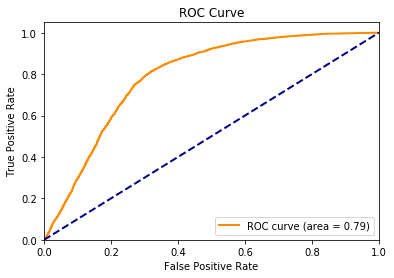

Iter 15150, Minibatch Loss= 0.561923, Training Accuracy= 0.66667
Iter 15300, Minibatch Loss= 0.594098, Training Accuracy= 0.66667
Iter 15450, Minibatch Loss= 0.421513, Training Accuracy= 0.80000
Iter 15600, Minibatch Loss= 0.492135, Training Accuracy= 0.66667
Iter 15750, Minibatch Loss= 0.480725, Training Accuracy= 0.80000
Validation Accuracy: 0.70488
Validation Loss: 0.56979746
Iter 15900, Minibatch Loss= 0.612939, Training Accuracy= 0.60000
Iter 16050, Minibatch Loss= 0.551935, Training Accuracy= 0.66667
Iter 16200, Minibatch Loss= 0.543918, Training Accuracy= 0.80000
Iter 16350, Minibatch Loss= 0.395937, Training Accuracy= 0.93333
Iter 16500, Minibatch Loss= 0.454453, Training Accuracy= 0.93333
Validation Accuracy: 0.75136
Validation Loss: 0.5368834


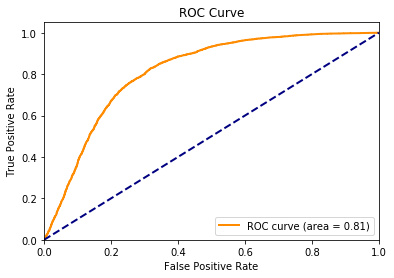

Iter 16650, Minibatch Loss= 0.589832, Training Accuracy= 0.66667
Iter 16800, Minibatch Loss= 0.536032, Training Accuracy= 0.66667
Iter 16950, Minibatch Loss= 0.590763, Training Accuracy= 0.53333
Iter 17100, Minibatch Loss= 0.649437, Training Accuracy= 0.53333
Iter 17250, Minibatch Loss= 0.441326, Training Accuracy= 0.80000
Validation Accuracy: 0.708
Validation Loss: 0.56700957
Iter 17400, Minibatch Loss= 0.552342, Training Accuracy= 0.86667
Iter 17550, Minibatch Loss= 0.689686, Training Accuracy= 0.46667
Iter 17700, Minibatch Loss= 0.393929, Training Accuracy= 0.86667
Iter 17850, Minibatch Loss= 0.523407, Training Accuracy= 0.66667
Iter 18000, Minibatch Loss= 0.402064, Training Accuracy= 0.86667
Validation Accuracy: 0.68824
Validation Loss: 0.6034324
Iter 18150, Minibatch Loss= 0.350393, Training Accuracy= 0.86667
Iter 18300, Minibatch Loss= 0.307341, Training Accuracy= 0.93333
Iter 18450, Minibatch Loss= 0.788117, Training Accuracy= 0.53333
Iter 18600, Minibatch Loss= 0.736747, Traini

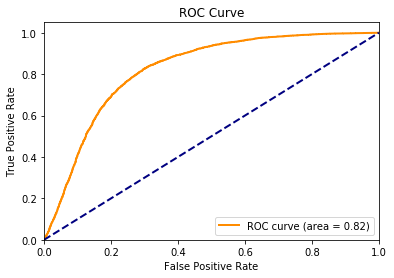

Iter 24900, Minibatch Loss= 0.313037, Training Accuracy= 0.93333
Iter 25050, Minibatch Loss= 0.693428, Training Accuracy= 0.60000
Iter 25200, Minibatch Loss= 0.354209, Training Accuracy= 0.86667
Iter 25350, Minibatch Loss= 0.544577, Training Accuracy= 0.73333
Iter 25500, Minibatch Loss= 0.544506, Training Accuracy= 0.66667
Validation Accuracy: 0.75744
Validation Loss: 0.5247171
Iter 25650, Minibatch Loss= 0.411683, Training Accuracy= 0.93333
Iter 25800, Minibatch Loss= 0.320718, Training Accuracy= 0.93333
Iter 25950, Minibatch Loss= 0.599081, Training Accuracy= 0.66667
Iter 26100, Minibatch Loss= 0.615541, Training Accuracy= 0.73333
Iter 26250, Minibatch Loss= 0.547811, Training Accuracy= 0.80000
Validation Accuracy: 0.69568
Validation Loss: 0.57549065
Iter 26400, Minibatch Loss= 0.506679, Training Accuracy= 0.73333
Iter 26550, Minibatch Loss= 0.511680, Training Accuracy= 0.73333
Iter 26700, Minibatch Loss= 0.699967, Training Accuracy= 0.53333
Iter 26850, Minibatch Loss= 0.482849, Trai

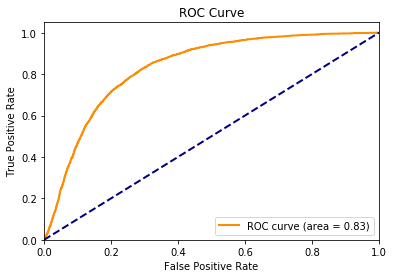

Iter 30900, Minibatch Loss= 0.521851, Training Accuracy= 0.73333
Iter 31050, Minibatch Loss= 0.629098, Training Accuracy= 0.60000
Iter 31200, Minibatch Loss= 0.536807, Training Accuracy= 0.80000
Iter 31350, Minibatch Loss= 0.765383, Training Accuracy= 0.46667
Iter 31500, Minibatch Loss= 0.599751, Training Accuracy= 0.73333
Validation Accuracy: 0.724
Validation Loss: 0.5464968
Iter 31650, Minibatch Loss= 0.457352, Training Accuracy= 0.80000
Iter 31800, Minibatch Loss= 0.587310, Training Accuracy= 0.73333
Iter 31950, Minibatch Loss= 0.623500, Training Accuracy= 0.60000
Iter 32100, Minibatch Loss= 0.614099, Training Accuracy= 0.60000
Iter 32250, Minibatch Loss= 0.380062, Training Accuracy= 0.86667
Validation Accuracy: 0.76408
Validation Loss: 0.5218785
Iter 32400, Minibatch Loss= 0.499742, Training Accuracy= 0.80000
Iter 32550, Minibatch Loss= 0.573003, Training Accuracy= 0.73333
Iter 32700, Minibatch Loss= 0.584602, Training Accuracy= 0.66667
Iter 32850, Minibatch Loss= 0.532277, Trainin

In [ ]:
%%time
best_test_acc = -1.0
sess = tf.Session()

# Launch the graph
if True:
    sess.run(init)
    test_data, test_label, test_seqlen, test_dnn = dataset.get_test_batch()
    test_dict = {
        x: test_data, 
        y: test_label,
        seqlen: test_seqlen, 
        x2: test_dnn,
        lstm_keep_prob: 1.00,
        fc_keep_prob: 1.00
    }
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen, batch_dnn = dataset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={
            x: batch_x, 
            y: batch_y,
            seqlen: batch_seqlen, 
            x2: batch_dnn,
            lstm_keep_prob: config.lstm_keep_prob,
            fc_keep_prob: config.fc_keep_prob
        })
        
        eval_dict = {
            x:      batch_x, 
            y:      batch_y,
            seqlen: batch_seqlen, 
            x2:     batch_dnn,
            lstm_keep_prob: 1.00,
            fc_keep_prob:   1.00
        }
        
        if should_log_metrics:
            acc = sess.run(accuracy, feed_dict=eval_dict)
            loss = sess.run(cost, feed_dict=eval_dict)
            line_start = str(step*batch_size) + ","
            train_loss_log.write(line_start + str(loss) + '\n')
            train_loss_log.flush()
            train_acc_log.write(line_start + str(acc) + '\n')
            train_acc_log.flush()

        if step % display_step == 0:
            if not should_log_metrics:
                acc = sess.run(accuracy, feed_dict=eval_dict)
                loss = sess.run(cost, feed_dict=eval_dict)
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
        if step % (display_step) == 0:
            if should_log_metrics:
                test_acc = sess.run(accuracy, feed_dict=test_dict)
                test_loss = sess.run(cost, feed_dict=test_dict)
                test_loss_log.write(line_start + str(test_loss) + '\n')
                test_loss_log.flush()
                test_acc_log.write(line_start + str(test_acc) + '\n')
                test_acc_log.flush()        
            if step % (5 * display_step) == 0:
                if not should_log_metrics:
                    test_acc = sess.run(accuracy, feed_dict=test_dict)
                    test_loss = sess.run(cost, feed_dict=test_dict)
                print("Validation Accuracy:", test_acc)
                print("Validation Loss:", test_loss)
                
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    # Plot ROC
                    answers = sess.run(tf.nn.softmax(logits), feed_dict=test_dict)
                    if label == 'good':
                        fpr, tpr, _ = roc_curve(1 - np.argmax(test_label, axis=1), answers[:, 0])
                    else:
                        fpr, tpr, _ = roc_curve(np.argmax(test_label, axis=1), answers[:, 1])
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    lw = 2
                    plt.plot(fpr, tpr, color='darkorange',
                             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC Curve')
                    plt.legend(loc="lower right")
                    plt.savefig('plots/' + run_name + '_step_' + str(step) + '.png', dpi=300, bbox_inches='tight')
                    plt.show()
        
        if step % save_every == 0:
            save_path = saver.save(sess, save_fn)
            print("Checkpoint saved at %s" % save_path)
        step += 1
    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_fn)
    print("Checkpoint saved at %s" % save_path)

    # Calculate accuracy
    print("Final Testing Accuracy:", sess.run(accuracy, feed_dict=test_dict))

### Read out the final weight matrix and save it to disk

In [ ]:
w = sess.run(weights)
n_fc = len(fc_layer_sizes) + 1

for i in range(n_fc):
    f_name = 'weights/' + label + '_dim_' + str(i) + '.csv'
    np.savetxt(f_name, w[i], delimiter=',')